In [149]:
#!jupyter nbconvert --to script dotifsetc.ipynb

In [150]:
import numpy as np
from scipy import constants
import scipy.interpolate
import time
import math
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import dotifs_util as util
#np.set_printoptions(threshold=np.inf)
np.set_printoptions(threshold=1000)
#from astropy.io import ascii
#from astropy.io import fits
#from astropy.table import Table
#import scipy
#from astropy.constants import h, c
#%matplotlib inline
#????
#t1=time.time()
#plt.ioff()


In [151]:
def gen_cal(wave, cdir, calname):
    calfilename=cdir+'calibration_line_list_'+calname+'_171024.txt'
    calfile=ascii.read(calfilename, data_start=0, format='basic')
    lwave=calfile.columns[0]
    lflux=calfile.columns[1]
            
    nline=len(lwave)
    nwave=len(wave)
    flux_out=wave*0.
    
    for i in range(nline):
        if (lwave[i] < wave[0]) or (lwave[i] > wave[-1]):
            continue
        diff=np.absolute(wave-lwave[i])
        sort_idx=np.argsort(diff)
        nrst_idx=sort_idx[0]
        if nrst_idx == (len(wave)-1):
            continue
        binsize=wave[nrst_idx+1]-wave[nrst_idx]
        nflux=lflux[i]/binsize
        flux_out[nrst_idx]=nflux*1e-17
    return flux_out     

In [152]:
def return_littrow_ghost(wave, signal, ccdreflect, cam, g1stR, g1st, g0th):
#       lghost=return_littrow_ghost(wave,signal+skysignal, ccdreflect, camtrans, g1stR, g1st, g0th)
    rsub=0.01 #;reflectivity of the grating substrate
    lghost1=np.sum(signal*ccdreflect*cam*cam*g1stR)
    lghost2=np.sum(signal*ccdreflect*cam*cam*g1st*rsub*g0th)
    print('Littrow ghost 1 and 2 ', lghost1, lghost2)
    lgwave=4800.
    lghost=signal*0

    diff=np.absolue(wave-lgwave)
    sort_idx=np.argsort(diff)
    nrst_idx=sort_idx[0]
    binsize=wave[nrst_idx+1]-wave[nrst_idx]
    

    tghost=(lghost1+lghost2)
    
    lghost[nrst_idx]=tghost
    return lghost

In [153]:
class readdata:
    def __init__(self, cdir, category, item, skiprows=0, datacol=1):
        cat_file=cdir+category+'/'+category+'.fmt'
        cat_str=np.loadtxt(cat_file, usecols=(0,1), dtype=str)
        cat_factor=np.loadtxt(cat_file, usecols=(2,3), dtype=float)
        
        arr=cat_str[:,0]
        
        if category =='sky_templates':
            skiprows=37
            if type(item) == int:
                ridx=[item]
            else:
                ridx=np.flatnonzero(arr == item)
        else:
            ridx=np.flatnonzero(arr == item)
        
        data_file=cdir+category+'/'+cat_str[ridx[0],1]

        data=np.loadtxt(data_file, usecols=(0,datacol), dtype=float,
                        skiprows=skiprows)
        self.name=cat_str[ridx[0],0]

        self.wave=data[:,0]*cat_factor[ridx[0],0]
        self.value=data[:,1]*cat_factor[ridx[0],1]

In [154]:
def interp(rdclass, xnew,itpkind='linear', itpfillvalue="extrapolate"):
    itpfunc=scipy.interpolate.interp1d(rdclass.wave, rdclass.value, kind=itpkind, fill_value=itpfillvalue)
    return itpfunc(xnew)#*((xnew >= min(rdclass.wave)) & (xnew <= max(rdclass.wave)))

In [162]:
class dotifsetc(object):
    def __init__(self, exptime=3600, band='r', magnitude=20., skymagnitude=22,
                 oname='snr.ps', galtemp=False, z=0., source='gal_sc', stype=0, 
                 wstep=(3700./3000), pixel=None, ltrghost=False, scflag=False, 
                 wavearr=None, inputflux=None, inputwave=None, 
                 plot=True, show=True, save=True, plotrange=[3700, 7400], cdir='./',
#                  cdir='/home/hchung/dotifs/py_etc/',
                 itpkind='linear', itpfillvalue="extrapolate", 
#                  dtypes=None, ofile='outdata.txt', 
                 pri=3.6, sec=0.915, skysamplingsize=0.4**2*math.pi, dispersion=3700/(3000*15), pixelsize=15,
                 npix_spa=5, rn=2, dark=0, bbtemp=5000, basewaverange=[2900,8000.],
                ):
        
        #define essential parameters as self attributes

        
        ncol=7
        ncam=9
        
        t1=time.time()

        consth=constants.h
        constc=constants.c
        temptitle='None'

        ifutrans=0.85*0.9
        telaream2=(pri**2-sec**2)/4*math.pi         #in m^2
        telarea=telaream2*1e4                           #in cm^2
        pixelscale=dispersion*pixelsize
        if pixel != None:
            wstep=pixel*pixelscale
        if pixel == None:
            pixel=wstep/pixelscale
            
        
        self.exptime=exptime
        self.band=band
        self.magnitude=magnitude
        self.z=z
        self.wstep=wstep
        self.pixel=pixel
        self.skymagnitude=skymagnitude
        self.oname=oname
        self.source=source
        self.show=show
        self.save=save
        self.ltrghost=ltrghost
        self.scflag=scflag
            

        stwave=plotrange[0]
        edwave=plotrange[1]
        
        if wavearr == None:
            nwave=int((basewaverange[-1]-basewaverange[0])/wstep)+1
            wave=np.linspace(0, nwave-1, num=nwave)*wstep+basewaverange[0]
            diffwave=wave-stwave
            abovezeroidx=np.nonzero(diffwave >=0)
            offwave=min(diffwave[abovezeroidx])
            wave=wave-offwave
        else:
            wave=np.array(wavearr)
            nwave=len(wavearr)
        
        tsky=interp(readdata(cdir, 'response_curves','sky'),wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        telmag=interp(readdata(cdir, 'response_curves','telmag'),wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        col=interp(readdata(cdir, 'response_curves','col'),wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        cam=interp(readdata(cdir, 'response_curves','cam'),wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        vph=interp(readdata(cdir, 'response_curves','vph'),wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        coat=interp(readdata(cdir, 'response_curves','coating', datacol=4),wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        ccd=interp(readdata(cdir, 'response_curves','ccd'),wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        bandt=interp(readdata(cdir, 'response_curves',band),wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        mg0th=interp(readdata(cdir, 'response_curves','mvph_0th'),wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        mg1st=interp(readdata(cdir, 'response_curves','mvph_1st'),wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        mg2nd=interp(readdata(cdir, 'response_curves','mvph_2nd'),wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        afilter=interp(readdata(cdir, 'response_curves','filter'),wave,itpkind=itpkind, itpfillvalue=itpfillvalue)

        col=col/0.995**(2*ncol)*coat**(2*ncol)
        cam=cam/0.995**(2*ncam)*coat**(2*ncam)

        g1st=vph
        g0th=vph/mg1st*mg0th
        g2nd=g1st/mg1st*mg2nd
        g1stR=g1st*5*10.**(-5)

        skyflag=0
        photone=consth*1e7*constc/(wave*1e-10)
        
        if (inputflux != None) & (inputwave != None):
            if (len(inputflux) == len(inputwave)):
                itpfunc=scipy.interpolate.interp1d(inputwave, inputflux, kind=itpkind, fill_value=itpfillvalue)
                sourceflux=itpfunc(wave)
        else:
            sourceflux, temptitle, skyflag, calflag=self.return_flux(source, wave, magnitude, bandt, z, 
                                                                exptime, wstep, cdir, bbtemp, stype, 
                                                                itpkind=itpkind, itpfillvalue=itpfillvalue)
            

        skyflux, skytemptitle, n2, n3=self.return_flux('sky', wave, skymagnitude, bandt, z,                             
                                    exptime, wstep, cdir, bbtemp, stype, itpkind=itpkind, itpfillvalue=itpfillvalue)

        
        sourcecount=(sourceflux/photone)*wstep*telarea*exptime*skysamplingsize
        skycount=(skyflux/photone)*wstep*telarea*exptime*skysamplingsize

        comtrans=telmag*ifutrans*col*afilter*cam*ccd
        t1st=comtrans*g1st
        t2nd=comtrans*g2nd*0.5   

        pc1st=t1st*sourcecount
        pc2nd=t2nd*sourcecount

        if skyflag == 1:
            pc1st=pc1st*tsky
            pc2nd=pc2nd*tsky

        skypc1st=t1st*skycount
        skypc2nd=t2nd*skycount

        wave2nd=wave*2
        itpfunc=scipy.interpolate.interp1d(wave2nd, pc2nd, kind=itpkind, fill_value=itpfillvalue)
        pc2nd=itpfunc(wave)
        
        itpfunc=scipy.interpolate.interp1d(wave2nd, skypc2nd, kind=itpkind, fill_value=itpfillvalue)
        skypc2nd=itpfunc(wave)


        if scflag == False:
            pc2nd=pc2nd*0.
            skypc2nd=skypc2nd*0.

        rn_t=rn*(npix_spa*pixel)**0.5
        dark_t=dark*exptime/3600.*(npix_spa*pixel)**0.5

        signal=pc1st+pc2nd

        skysignal=skypc1st+skypc2nd
        if calflag == 1:
            skysignal=skysignal *0.

        if ltrghost == True:
            lghost=return_littrow_ghost(wave,signal+skysignal, (1-ccd), cam, g1stR, g1st, g0th)
            signal=signal+lghost

        #;print, dark, exptime, npix_spa, pixel, dark_t, rn_t, mean((signal+2*skysignal)^0.5)
        noise_poisson=(signal+skysignal+rn_t**2+dark_t**2)**0.5
        noise_sky=(skysignal+rn_t**2+dark_t**2)**0.5
        noise_2nd=pc2nd
        noise=(noise_poisson**2+noise_sky**2)**0.5
        #;       noise_total=noise_poisson+noise_sky
        nfrac_poisson=signal/noise
        nfrac_sky=skysignal*2/noise
        nfrac_rn=2**0.5*rn_t/noise
        nfrac_dark=2**0.5*dark_t/noise
        snr=signal/noise
        pc2vsntotal=pc2nd/noise

        #print(snr[idx])

        #########
        idx=np.nonzero((wave >= stwave) & (wave <= edwave))
        self.sourceflux=sourceflux[idx]
        self.wave=wave[idx]
        self.snr=snr[idx]
        self.signal=signal[idx]
        self.skysignal=skysignal[idx]
        self.noise_sky=noise_sky[idx]
        self.noise=noise[idx]
        self.nfrac_poisson=nfrac_poisson[idx]
        self.nfrac_sky=nfrac_sky[idx]
        self.pc2vsntotal=pc2vsntotal[idx]
        self.pc2nd=pc2nd[idx]
        self.skyfrac=nfrac_sky[idx]
        self.rnfrac=nfrac_rn[idx]
        self.temptitle=temptitle
        self.skytemptitle=skytemptitle
        
        if plot:
            self.plot()
            
    def return_flux(self, source, wave, magnitude, bandt, z, exptime, wstep, cdir, 
                    bbtemp, stype, itpkind='linear', itpfillvalue='extrapolate'):
     #Identify source type
        consth=constants.h
        constc=constants.c
        src_check=source.split('_')
        src_type=src_check[0]
        skyflag=0
        calflag=0
        if len(src_check) == 2:
            src_value=src_check[1]


        nwave=len(wave)

        if src_type =='const':
            magarr=np.ones(nwave)*magnitude
            photone=consth*1e7*constc/(wave*1e-10)
            sourceflux=util.mag2flux(magnitude, ABwave=wave)
            temptitle='Constant Magnitude of '+str(magnitude)
            calflag=1

        if src_type =='gal':
            gal=readdata(cdir, 'target_templates',src_value)
            galwave=gal.wave*(1.+z)
            galflam=gal.value/(1.+z)
            galtempname=src_value

            itpfunc=scipy.interpolate.interp1d(galwave, galflam, kind=itpkind,fill_value=itpfillvalue)
            galflux=itpfunc(wave)

            bpmag=util.flux2bpmag(galflux, wave, bandt)

            ratio=10.**(-0.4*(magnitude-bpmag))
            sourceflux=ratio*galflux

            sourceflux=sourceflux*((wave >= min(galwave)) & (wave <= max(galwave)))
            sfb_str='m$_{'+str(self.band)+'}$ = '+str(self.magnitude)+' mag/arcsec$^{2}$'
            z_str='z='+str(self.z)
            temptitle=src_value+', ('+sfb_str+', '+z_str+')'
            skyflag=1

    #    if src_type =='skyflat':

        if src_type =='arcflat':
            arcfile=readdata(cdir, 'calibration',src_value)
            xwave=arcfile.columns[0]
            xflam=arcfile.columns[1]

            itpfunc=scipy.interpolate.interp1d(xwave, xflam , kind=itpkind, fill_value=itpfillvalue)
            sourceflux=itpfunc(wave)

            sourceflux=sourceflux*((wave >= min(xwave)) & (wave <= max(xwave)))
            temptitle='Xenon Arc Lamp'
            calflag=1

        if src_type =='blackbody':
            sourceflux=util.planck(wave, bbtemp)*0.015**2.*np.pi/(1e5)**2
            temptitle='Black Body (T='+str(bbtemp)+' K'
            calflag=1

        if src_type =='wavecal':
            sourceflux=gen_cal(wave, cdir, src_value)
            temptitle='Wavelength Calibration Source - '+src_value
            calflag=1

        if src_type =='sky':
            skyfile=readdata(cdir, 'sky_templates',stype)

            skywave=skyfile.wave
            skyunitcount=skyfile.value

            skyphotone=consth*1e7*constc/(skywave*1e-10)
            skycount=skyunitcount*1e-4*1e-4
            skyflam=skycount*skyphotone

            itpfunc=scipy.interpolate.interp1d(skywave, skyflam, kind=itpkind, fill_value=itpfillvalue)
            skyflux=itpfunc(wave)

            skyflux=skyflux*((wave >= min(skywave)) & (wave <= max(skywave)))

            bpmag=util.flux2bpmag(skyflux, wave, bandt)
            if magnitude != None:
                ratio=10.**(-0.4*(magnitude-bpmag))
                skyflux=ratio*skyflux
            sourceflux=skyflux
            sfb_str='m$_{'+str(self.band)+'}$ = '+str(self.skymagnitude)+' mag/arcsec$^{2}$'
            temptitle=skyfile.name+', ('+sfb_str+')'
            calflag=1

        return sourceflux, temptitle, skyflag, calflag

            
    def plot(self):
        
        matplotlib.rcParams.update({'font.size':15})
        font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}

        upmar=1.04
        lwmar=0.995
        wavemar=200

        matplotlib.rc('font', **font)

        xlim=[min(self.wave)-wavemar,max(self.wave)+wavemar]

        plt.clf
        fig=plt.figure(figsize=(8.27,11.69))
        gs1=gridspec.GridSpec(4,1, left=None, bottom=0.1, right=0.95, top=0.82, wspace=None, hspace=None)
        gs1.update(hspace=0.0)
        ax0=plt.subplot(gs1[0])
        ax0.plot(self.wave, self.sourceflux/1e-17, 'k', linestyle='-')
        ax0.set_xlim(xlim)
        ax0.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
        ax0.set_ylabel("$f_{\lambda}\;(10^{-17} erg/s/cm^{2}/\AA$)")



        ax1=plt.subplot(gs1[1])
        ax1.plot(self.wave, self.snr, 'k', linestyle='-')
        ax1.set_ylabel("S/N")
        ax1.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
        ax1.set_xlim(xlim)

        ax2=plt.subplot(gs1[2])
        ax2.plot(self.wave, self.signal, 'k', linestyle='-')
        ax2.set_xlim(xlim)
        ax2.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
        ax2.set_ylabel("Signal Count")

        ax3=plt.subplot(gs1[3])
        ax3.plot(self.wave, self.noise, 'r', linestyle='-')
        ax3.set_xlim(xlim)
        ax3.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
        ax3.set_xlabel("Wavelength ($\AA$) ")
        ax3.set_ylabel("Noise Count")

        ax0.tick_params(labelbottom=False)#, length=0)
        ax1.tick_params(labelbottom=False)#, length=0)
        ax2.tick_params(labelbottom=False)#, length=0)
        
        

        remarks=[time.asctime( time.localtime(time.time()) ),
                 'DOTIFS S/N Calculator (ver 26/07/18)',
                 'Target: '+self.temptitle,
#                 'Surface Birghtness: m$_{'+str(self.band)+'}$ = '+str(self.magnitude)+' mag/arcsec$^{2}$',
#                 'Redshift: z='+str(self.z),
                 'Sky (mssep_mtsep_malt_talt): '+self.skytemptitle,
                 'Exposure time: '+str(self.exptime)+' sec',
                 '$\Delta\lambda$: '+str(round(self.wstep, 3))+ '$\AA$ ('+str(round(self.pixel,3))+' pixels)',
                ]

        remarks2='\n'.join(remarks)

        nremarks=len(remarks)

        axc = fig.add_axes([0.000001,0,1,1], facecolor="None", frameon=False, label="")
        axc.tick_params(labelbottom=False, labelleft=False, length=0)

        yitv=0.02
        ax = fig.add_axes([0,0,1,1], facecolor="None", frameon=False, label="")
        ax.tick_params(labelbottom=False, labelleft=False, length=0)
        ax.text(0.95, 0.83, remarks2,horizontalalignment='right', size=12, linespacing=1)

        
#         if self.show == True:
#             plt.show()

        if self.save == True:
            fig.savefig(self.oname, bbox_inches='tight')
        
        
def aaa(self, exptime=3600, band='r', magnitude=20., skymagnitude=22,
        oname='snr.ps', galtemp=False, z=0., source='gal_sc', stype=0, 
        wstep=(3700./3000), pixel=None, ltrghost=False, scflag=False, 
        wavearr=None, inputflux=None, inputwave=None, 
        plot=True, plotrange=[3700, 7400], cdir='./'):
    return


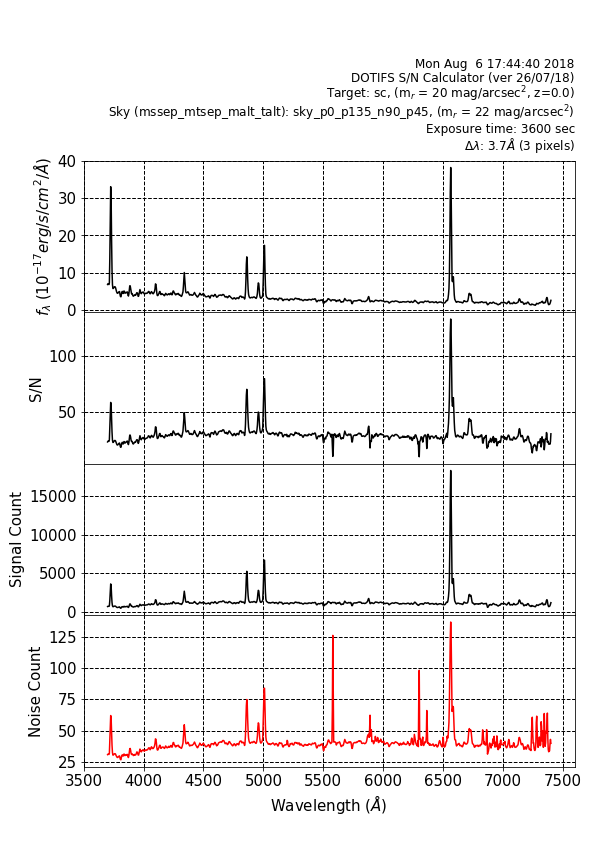

In [163]:
r1=dotifsetc(exptime=3600, pixel=3, magnitude=20, plot=True, save=False)
#r1=dotifsetc(exptime=3600, pixel=3, magnitude=20)